## Semantic Segmentation

 Implementing the sematic segmentation with the VOC Dataset

**Understand the PASCAL VOC dataset http://host.robots.ox.ac.uk/pascal/VOC/voc2012/index.html#data**

The Pascal VOC (Visual Object Classes) dataset serves as a key benchmark in computer vision, offering a comprehensive collection of images annotated with object categories and segmentation masks. Split into training and validation sets, annotations provided in XML format facilitate tasks like object recognition. Within the annotations, a 'segment' tag set as 1 signifies images primed for segmentation tasks. Segmented images, derived from either original_masks or binary_masks, can be depicted separately for each class by accessing their BGR format, allowing for precise visualization and analysis

**Understand the definition of semantic segmentation**
Semantic segmentation is a computer vision task that involves assigning each pixel in an image a label so that machines can recognize objects and their meanings. Semantic segmentation is commonly used for vision tasks that require absolute precision.

**Understanding annotation format**
The annotation format includes the name of each object and the bounding box coordinates (xmin, xmax, ymin, ymax) within the <object> tag for object detection. Additionally, a segment tag marked as 1 indicates that the image is segmented.

**How will you define IOU for a segmentation task? How mid it different from the IOU for an object detection task?**
**Segmentation IoU:** Evaluates the overlap of predicted and ground truth masks at the pixel level, demanding precise alignment of object boundaries.**Object Detection IoU:** Evaluates the overlap of predicted and ground truth bounding boxes, focusing on the overall region of object presence rather than exact shape

.
### Importing library
- **os**: For interacting with the operating system.
- **xml.etree.ElementTree**: For parsing XML files.
- **numpy**: For numerical operations on arrays.
- **matplotlib.pyplot**: For plotting images and graphs.
- **PIL**: For image processing.
- **cv2**: OpenCV library for computer vision tasks.
asks.

In [22]:
import os
import xml.etree.ElementTree as ET
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw
import cv2

###  Function to Create Semantic segmentation mask

This function generates a semantic segmentation mask based on the provided segmentation data. It iterates through each class label and its corresponding segmentation coordinates, then fills the mask with the specified class index obtained from the class-to-index mapping. Finally, it returns the generated mask.

In [31]:
def create_segmentation_mask(image_shape, segmentation_data, class_to_index):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    for class_label, seg_coords_list in segmentation_data:
        class_idx = class_to_index.get(class_label, 0)  # Get the class index from the class_to_index mapping
        for seg_coords in seg_coords_list:
            flattened_coords = [point for sublist in seg_coords for point in sublist]
            pts = np.array(flattened_coords, np.int32)
            pts = pts.reshape((-1, 1, 2))
            cv2.fillPoly(mask, [pts], class_idx)
    return mask

### Function to Parse XML and Extract Bounding Boxes

This function is necessary for extracting bounding box annotations from XML files commonly used in object detection tasks. It is needed to convert the XML annotations into a format that can be easily processed and utilized in further steps of the object detection pipeline, such as drawing bounding boxes on images or generating training data for machine learning models.

It iterates through each <object> tag in the XML file, extracts the class label and bounding box coordinates (xmin, ymin, xmax, ymax), and returns them as tuples of points: (xmin, ymin, xmax, ymax), representing the top-left and bottom-right corners of each bounding box.

In [24]:
# Function to parse XML and extract bounding boxes
def parse_annotation(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()
    bboxes = []
    for obj in root.findall('object'):
        class_label = obj.find('name').text
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)
        bboxes.append((class_label, (xmin, ymin, xmax, ymax)))
    return bboxes


### Function to Draw Bounding Boxes on the Segmentation Mask


The function draw_bounding_boxes_on_mask serves the purpose of visually annotating a mask image with bounding boxes and class labels. Initially, the input mask image is converted to BGR format, which is essential for color drawing. Subsequently, the mask regions are colore  to enhance visibility

The function then iterates through a list of bounding boxes provided as input. For each bounding box, it draws a rectangle on the mask image using OpenCV, utilizing the specified color corresponding to the class label. Additionally, the class label is annotated adjacent to the bounding box to signify the type of object it represents.
.

In [54]:
def draw_bounding_boxes_on_mask(mask, bboxes, class_to_color):
    mask_bgr = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)  # Convert mask to BGR format for color drawing
    mask_bgr[mask != 0] = [0, 255, 255]  # Set the mask color to yellow
    for class_label, (xmin, ymin, xmax, ymax) in bboxes:
        color = class_to_color.get(class_label, (255, 255, 255))  # Default to white if class not found
        cv2.rectangle(mask_bgr, (xmin, ymin), (xmax, ymax), color, 2)
        cv2.putText(mask_bgr, class_label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)
    return mask_bgr


### Function to Process Masks and Simulate Predicted Masks

The process_masks function is designed to load a segmentation mask image, apply erosion and dilation operations to simulate predicted masks, and return both the true mask and the simulated predicted mask

1. **Loading the Segmentation Mask**: The function loads the input segmentation mask image using PIL (Python Imaging Library) and converts it to a grayscale image.
2. **Erosion and Dilation Operations**: These operations, implemented through OpenCV's cv2.erode and cv2.dilate functions, respectively, modify the true mask. Erosion reduces the size of foreground objects while dilation enlarges them. These operations help simulate changes in object boundaries, which can be valuable for assessing the performance of segmentation algorithms under different conditions.
3. **Simulating Predicted Masks**: After applying erosion and dilation, the function generates a simulated predicted mask. It iterates over each pixel in the dilated mask and assigns a binary value to it based on predefined probabilities (prob_true_positive and prob_false_positive). This step mimics the process of predicting segmentation masks in real-world scenarios.

.

In [47]:
# Load Segmentation Mask and Simulate Predicted Masks
def process_masks(mask_file, prob_true_positive=0.9, prob_false_positive=0.05, kernel_size=(3, 3)):
    mask = Image.open(mask_file).convert("L")
    true_mask = np.array(mask)

    # Apply erosion and dilation to the true mask
    kernel = np.ones(kernel_size, np.uint8)
    eroded_mask = cv2.erode(true_mask, kernel, iterations=1)
    dilated_mask = cv2.dilate(eroded_mask, kernel, iterations=1)

    pred_mask = np.zeros_like(dilated_mask, dtype=int)

    for y in range(dilated_mask.shape[0]):
        for x in range(dilated_mask.shape[1]):
            if dilated_mask[y, x] != 0:
                pred_mask[y, x] = int(np.random.rand() < prob_true_positive)
            else:
                pred_mask[y, x] = int(np.random.rand() < prob_false_positive)

    return true_mask, pred_mask


### Function to Calculate Intersection over Union (IoU)

1. **Intersection:** 
Use np.logical_and to find the intersection between gt_mask and pred_mask. The sum of the intersection array gives the total number of overlapping pixel
2. **Union:** 
Use np.logical_or to find the union between gt_mask and pred_mask. The sum of the union array gives the total number of pixels that are part of either mas
3. **IoU Calculation:** 
Compute the IoU as the ratio of the intersection to the union.
If the union is 0 (which can happen if both masks are empty), return 0 to avoid division by zero.k.s.

In [1]:
def compute_iou(gt_mask, pred_mask):
    intersection = np.logical_and(gt_mask, pred_mask).sum()
    union = np.logical_or(gt_mask, pred_mask).sum()
    if union == 0:
        return 0
    return intersection / union


### Function to Display Images and Masks

In [2]:
def display_images_masks(img_file, annot_file, mask_file):
    image = Image.open(img_file).convert("RGB")
    true_mask, pred_mask = process_masks(mask_file)
    iou = compute_iou(true_mask, pred_mask)

    # Load the segmentation mask image and extract segmentation coordinates
    segmentation_mask_image = cv2.imread(mask_file, cv2.IMREAD_GRAYSCALE)
    _, binary_mask = cv2.threshold(segmentation_mask_image, 127, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    segmentation_coordinates = [[contour.squeeze().tolist()] for contour in contours]

    # Define the segmentation data
    segmentation_data = [('bus', segmentation_coordinates), ('aeroplane', segmentation_coordinates)]  # Example

    # Create segmentation mask
    segmentation_mask = create_segmentation_mask(np.array(image).shape, segmentation_data, class_to_index)

    # Parse annotation XML
    bboxes = parse_annotation(annot_file)

    # Draw bounding boxes with labels on the segmentation mask with different colors
    class_to_color = {'bus': (0, 165, 255), 'aeroplane': (42, 42, 165)}  # Example: {'class_label': (B, G, R)}
    segmentation_mask_with_bboxes = draw_bounding_boxes_on_mask(segmentation_mask, bboxes, class_to_color)

    # Display True Image
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title("Image")
    plt.axis('off')
    plt.show()

    # Display Segmentation with Bounding Boxes
    plt.figure(figsize=(5, 5))
    plt.imshow(segmentation_mask_with_bboxes)
    plt.title("Segmentation Mask with Bounding Boxes")
    plt.axis('off')
    plt.show()
    image = Image.open(mask_file).convert("RGB")
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.title("ground truth")
    plt.axis('off')
    plt.show()
    # Display True Mask and Predicted Mask
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(true_mask, cmap='gray')
    axes[0].set_title(f"True Mask:")
    axes[0].axis('off')

    axes[1].imshow(pred_mask, cmap='gray')
    axes[1].set_title(f"Predicted Mask ")
    axes[1].axis('off')

    axes[2].text(0.5, 0.5, f"IoU: {iou:.2f}", fontsize=15, ha='center', va='center')
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

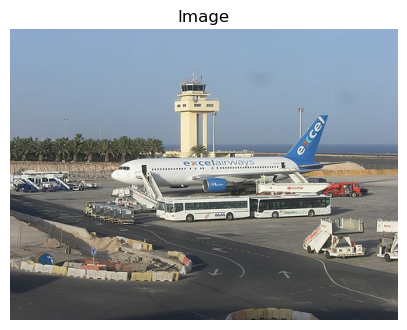

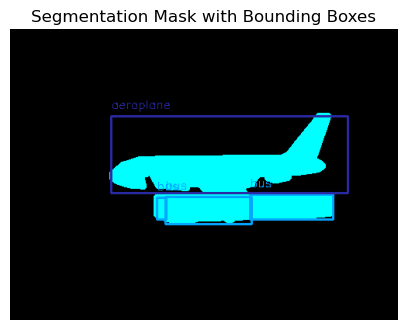

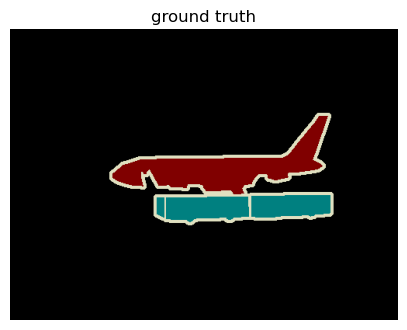

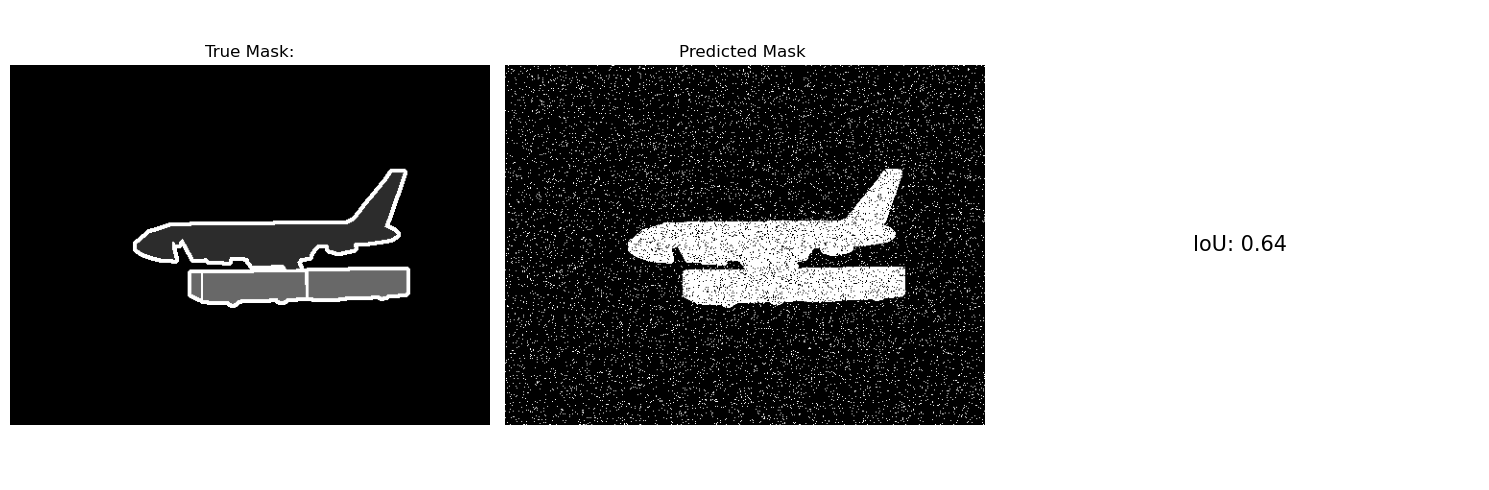

In [66]:
# Main Function
def main():
    img_file = "2007_001884.jpg"
    annot_file = "2007_001884.xml"
    mask_file = "2007_001884.png"
    display_images_masks(img_file, annot_file, mask_file)

if __name__ == "__main__":
    main()
